In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffusion import DiffusionModel, TargetType
from models import UNet
from google.colab import drive
drive.mount('/content/drive')

img_path = '/content/drive/MyDrive/sprites_1788_16x16.npy'
labels_path = '/content/drive/MyDrive/sprite_labels_nc_1788_16x16.npy'

images = np.load(img_path)
labels = np.load(labels_path)

Mounted at /content/drive


In [2]:
labels.shape

(89400, 5)

In [3]:
images.shape

(89400, 16, 16, 3)

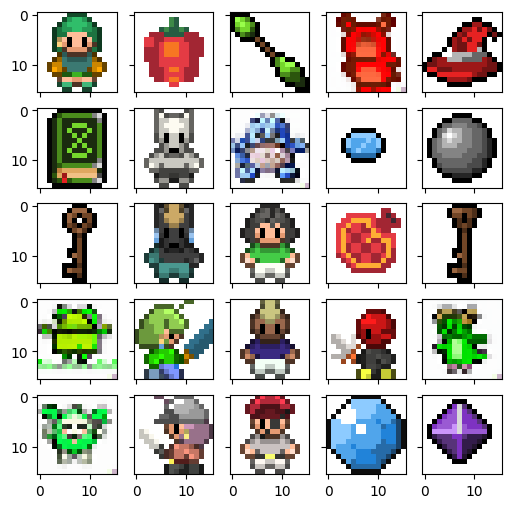

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(6, 6), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = images[random_characters]
    fig_x.imshow(im_val)
    fig_x.grid(False)

In [5]:
import torch
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.data = (torch.Tensor(np.transpose(images, (0, 3, 1, 2)) / 255) - 0.5) * 2
        self.labels = torch.argmax(torch.Tensor(labels), dim=1, keepdim=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [6]:
dataset = ImageDataset(images, labels)
batch_size = 256
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## DDPM predicting noise

In [ ]:
n_steps = 1000

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps)
n_epochs = 30
losses = diffusion_model.train(n_epochs, data_loader, len(dataset))

# best loss 0.023

1000it [00:15, 65.05it/s]


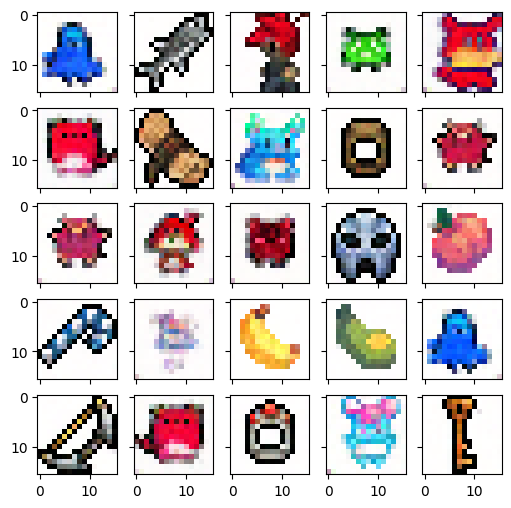

In [9]:
new_image = diffusion_model.sample(25)
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(6, 6), \
                        sharey=True, sharex=True)

new_images = np.transpose(new_image.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

## DDPM predicting signal itself

In [ ]:
n_steps = 500

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps, model_type=TargetType.X_START)
n_epochs = 30
diffusion_model.train(n_epochs, data_loader, len(dataset))

# best loss 0.135

500it [00:07, 62.93it/s]


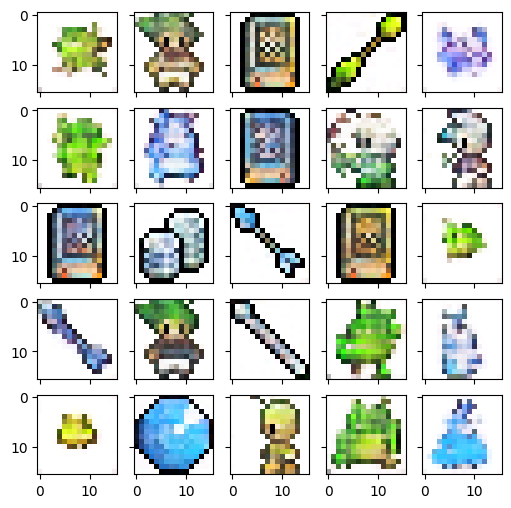

In [11]:
new_image = diffusion_model.sample(25)
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(6, 6), \
                        sharey=True, sharex=True)

new_images = np.transpose(new_image.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

## Conditional ddpm

In [ ]:
n_steps = 500

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps, n_classes=5).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps, is_conditioned=True)
n_epochs = 30
losses = diffusion_model.train(n_epochs, data_loader, len(dataset))

# best loss 0.029

In [15]:
labels = torch.Tensor([[0]] * 5 + [[1]] * 5 + [[2]] * 5 + [[3]] * 5 + [[4]] * 5).to(device).long()

500it [00:15, 32.89it/s]


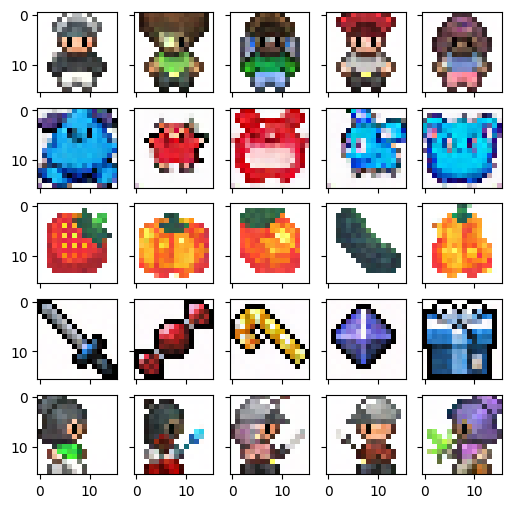

In [14]:
new_image = diffusion_model.sample(25, labels, 2)
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(6, 6), \
                        sharey=True, sharex=True)

new_images = np.transpose(new_image.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)